# This is the code script that implements all the Calculations for this assignment



In [593]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

def process_bond_data_from_csv(stm_csv_file, ltm_csv_file, date_key, selected_bonds_list):
    """Processes STM and LTM CSV files for a given date, filters bonds, cleans data."""
    try:
        stm_df = pd.read_csv(stm_csv_file, skiprows=[0, 1])
        ltm_df = pd.read_csv(ltm_csv_file, skiprows=[0, 1])
        combined_df = pd.concat([stm_df, ltm_df], ignore_index=True)
        processed_data = []
        processed_bond_identifiers = set()
        for coupon, maturity_date_str in selected_bonds_list:
            maturity_date = datetime.strptime(maturity_date_str, '%Y-%m-%d').date()
            coupon_str_search = f"{coupon:.2f}%"
            bond_identifier = (coupon, maturity_date)
            if bond_identifier in processed_bond_identifiers: continue
            bond_row = combined_df[(combined_df['Coupon'] == coupon_str_search) & (pd.to_datetime(combined_df['Maturity Date']).dt.date == maturity_date)]
            if not bond_row.empty:
                bond_row_unique = bond_row.iloc[[0]]
                processed_data.append(bond_row_unique)
                processed_bond_identifiers.add(bond_identifier)
        if not processed_data: return None
        processed_df = pd.concat(processed_data, ignore_index=True)
        processed_df = processed_df[['Coupon', 'Maturity Date', 'Close']]
        processed_df.rename(columns={'Maturity Date': 'MaturityDate', 'Close': 'CleanPrice'}, inplace=True)
        processed_df['MaturityDate'] = pd.to_datetime(processed_df['MaturityDate']).dt.date
        processed_df['Coupon'] = processed_df['Coupon'].str.rstrip('%').astype('float') / 100
        processed_df['ClosePrice'] = pd.to_numeric(processed_df['ClosePrice'])
        bond_names = []
        for index, row in processed_df.iterrows():
            coupon_percent = row['Coupon'] * 100
            maturity_date_fmt = row['MaturityDate'].strftime('%b %y')
            bond_names.append(f"CAN {coupon_percent:.2f} {maturity_date_fmt}")
        processed_df.index = bond_names
        return processed_df
    except FileNotFoundError: return None
    except Exception as e: return None


# --- Main script ---

selected_bonds = [(1.50, '2025-04-01'), (0.50, '2025-09-01'), (3.00, '2026-04-01'), (4.00, '2026-08-03'), (3.00, '2027-02-01'), (2.75, '2027-09-01'), (3.50, '2028-03-01'), (3.25, '2028-09-01'), (4.00, '2029-03-01'), (2.25, '2029-06-01'), (0.50, '2030-12-01')]
csv_file_directory = "./data/"
date_files = {"Jan 6th":  {"stm": "Jan 6th stm.csv", "ltm": "Jan 6th ltm.csv"}, "Jan 7th":  {"stm": "Jan 7th stm.csv", "ltm": "Jan 7th ltm.csv"}, "Jan 8th":  {"stm": "Jan 8th stm.csv", "ltm": "Jan 8th ltm.csv"}, "Jan 9th":  {"stm": "Jan 9th stm.csv", "ltm": "Jan 9th ltm.csv"}, "Jan 10th": {"stm": "Jan 10th stm.csv", "ltm": "Jan 10th ltm.csv"}, "Jan 13th": {"stm": "Jan 13th stm.csv", "ltm": "Jan 13th ltm.csv"}, "Jan 14th": {"stm": "Jan 14th stm.csv", "ltm": "Jan 14th ltm.csv"}, "Jan 15th": {"stm": "Jan 15th stm.csv", "ltm": "Jan 15th ltm.csv"}, "Jan 16th": {"stm": "Jan 16th stm.csv", "ltm": "Jan 16th ltm.csv"}, "Jan 17th": {"stm": "Jan 17th stm.csv", "ltm": "Jan 17th ltm.csv"}}

bond_data_dict = {}
for date_key, files in date_files.items():
    stm_file_path = f"{csv_file_directory}{files['stm']}"
    ltm_file_path = f"{csv_file_directory}{files['ltm']}"
    processed_df = process_bond_data_from_csv(stm_file_path, ltm_csv_file, date_key, selected_bonds)
    if processed_df is not None:
        bond_data_dict[date_key] = processed_df

NameError: name 'ltm_csv_file' is not defined

In [578]:
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

def calculate_accrued_interest(coupon_rate, maturity_date, valuation_date):
    """Calculates accrued interest for a bond."""
    maturity_month = maturity_date.month
    payment_months = set([(maturity_month - 6) % 12 or 12, maturity_month])
    last_coupon_date = None
    next_coupon_date = None
    current_date = maturity_date
    while current_date >= valuation_date:
        current_date -= relativedelta(months=6)
    last_coupon_date = current_date
    next_coupon_date = last_coupon_date + relativedelta(months=6)
    if last_coupon_date is None: last_coupon_date = valuation_date - relativedelta(months=6)
    if next_coupon_date is None: next_coupon_date = valuation_date + relativedelta(months=6)
    if last_coupon_date >= valuation_date: last_coupon_date = valuation_date - relativedelta(months=6)
    if next_coupon_date <= valuation_date: next_coupon_date = valuation_date + relativedelta(months=6)
    days_since_last_coupon = (valuation_date - last_coupon_date).days
    days_in_coupon_period = (next_coupon_date - last_coupon_date).days
    if days_in_coupon_period == 0: return 0.0
    accrued_interest = (coupon_rate / 2) * (days_since_last_coupon / 365) * 100
    return accrued_interest

for date_key, df in bond_data_dict.items():
    valuation_date_dt = datetime.strptime(date_key.split(' ')[0] + '-2025', '%b-%Y').date()
    dirty_prices = []
    for index, row in df.iterrows():
        if 'ClosePrice' not in row:
            continue
        accrued_interest_val = calculate_accrued_interest(row['Coupon'], row['MaturityDate'], valuation_date_dt)
        dirty_price = row['ClosePrice'] + accrued_interest_val
        dirty_prices.append(dirty_price)

    df['DirtyPrice'] = dirty_prices
    df.rename(columns={'CleanPrice': 'CleanPrice'}, inplace=True)


--- Processing date: Jan 6th ---
DataFrame columns before Dirty Price calculation: Index(['Coupon', 'MaturityDate', 'ClosePrice'], dtype='object')

--- Processing date: Jan 7th ---
DataFrame columns before Dirty Price calculation: Index(['Coupon', 'MaturityDate', 'ClosePrice'], dtype='object')

--- Processing date: Jan 8th ---
DataFrame columns before Dirty Price calculation: Index(['Coupon', 'MaturityDate', 'ClosePrice'], dtype='object')

--- Processing date: Jan 9th ---
DataFrame columns before Dirty Price calculation: Index(['Coupon', 'MaturityDate', 'ClosePrice'], dtype='object')

--- Processing date: Jan 10th ---
DataFrame columns before Dirty Price calculation: Index(['Coupon', 'MaturityDate', 'ClosePrice'], dtype='object')

--- Processing date: Jan 13th ---
DataFrame columns before Dirty Price calculation: Index(['Coupon', 'MaturityDate', 'ClosePrice'], dtype='object')

--- Processing date: Jan 14th ---
DataFrame columns before Dirty Price calculation: Index(['Coupon', 'Maturit

In [579]:
def bond_price_pv_ytm(ytm, coupon_rate, years_to_maturity, periods_per_year=2, face_value=100):
    """Calculates present value of bond given ytm."""
    ytm_period = ytm / periods_per_year
    coupon_period = coupon_rate / periods_per_year

    time_left = years_to_maturity * periods_per_year
    payment_times = [time_left]
    while time_left > 0:
        time_left = time_left - 1
        if time_left > 0:
            payment_times.insert(0, time_left)

    pv = 0
    for period in payment_times:
        pv += (coupon_period * face_value) / (1 + ytm_period)**period
    pv += face_value / (1 + ytm_period)**payment_times[-1]
    return pv

In [580]:
def calculate_ytm_binary_search(dirty_price, coupon_rate, maturity_date, valuation_date, tolerance=1e-6, max_iterations=200):
    """Calculates Yield to Maturity (YTM) using binary search."""
    low_yield = 0.02
    high_yield = 0.15
    years_to_maturity = (maturity_date - valuation_date).days / 365.25
    if years_to_maturity <= 0: return 0.0
    for _ in range(max_iterations):
        mid_yield = (low_yield + high_yield) / 2
        calculated_price = bond_price_pv_ytm(mid_yield, coupon_rate, years_to_maturity)
        price_difference = dirty_price - calculated_price
        if abs(price_difference) < tolerance: return mid_yield
        elif price_difference > 0: high_yield = mid_yield
        else: low_yield = mid_yield
    return None

In [581]:
def process_bond_data_dict_with_ytm(bond_data_dict):
    """Updates the bond_data_dict DataFrames to include 'TimeToMaturity' and 'YTM' columns."""
    for date_key, df in bond_data_dict.items():
        valuation_date_dt = datetime.strptime(date_key.split(' ')[0] + '-2025', '%b-%Y').date()
        time_to_maturities = []
        ytms = []
        for index, row in df.iterrows():
            years_to_maturity = (row['MaturityDate'] - valuation_date_dt).days / 365.25
            ytm_val = calculate_ytm_binary_search(row['DirtyPrice'], row['Coupon'], row['MaturityDate'], valuation_date_dt)

            time_to_maturities.append(years_to_maturity)
            ytms.append(ytm_val)

        df['TimeToMaturity'] = time_to_maturities
        df['YTM'] = ytms
    return bond_data_dict


--- Processing date for YTM: Jan 6th ---

--- YTM Calculation Start ---
Dirty Price: 99.82904109589042, Coupon Rate: 0.015, Maturity: 2025-04-01, Valuation: 2025-01-01
Years to Maturity: 0.2464065708418891

Iteration 1:
  Low Yield: 0.020000, High Yield: 0.150000, Mid Yield: 0.085000
  Calculated Price: 98.704496, Dirty Price: 99.829041, Difference: 1.124546
  Price difference > 0, updating high_yield

Iteration 2:
  Low Yield: 0.020000, High Yield: 0.085000, Mid Yield: 0.052500
  Calculated Price: 99.471655, Dirty Price: 99.829041, Difference: 0.357386
  Price difference > 0, updating high_yield

Iteration 3:
  Low Yield: 0.020000, High Yield: 0.052500, Mid Yield: 0.036250
  Calculated Price: 99.862071, Dirty Price: 99.829041, Difference: -0.033030
  Price difference <= 0, updating low_yield

Iteration 4:
  Low Yield: 0.036250, High Yield: 0.052500, Mid Yield: 0.044375
  Calculated Price: 99.666284, Dirty Price: 99.829041, Difference: 0.162757
  Price difference > 0, updating high_yi

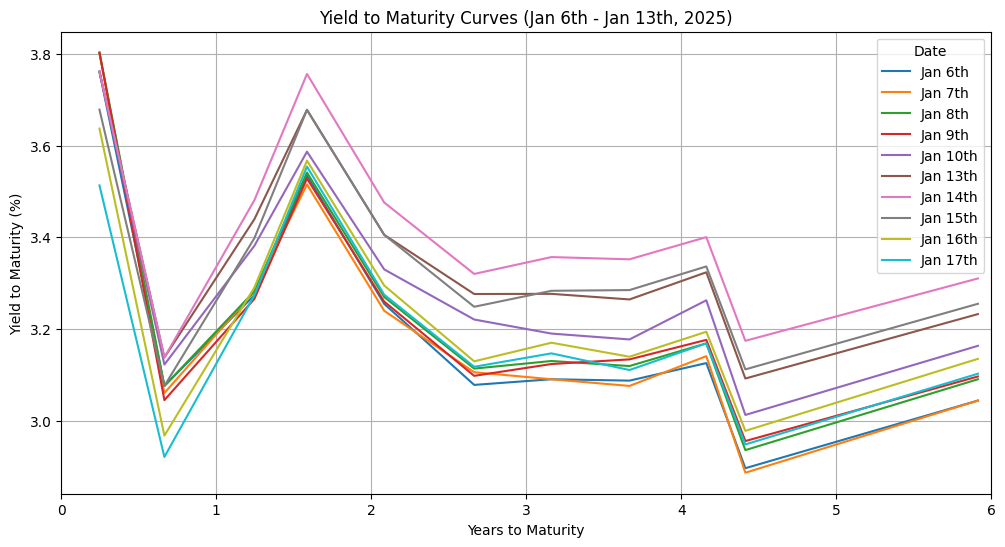


YTM curves calculated and plotted.


In [582]:
# --- Main Script ---

# Process bond_data_dict to calculate YTM
bond_data_dict_with_ytm = process_bond_data_dict_with_ytm(bond_data_dict.copy()) # Use .copy() to avoid modifying original dict

# --- Plotting YTM Curves ---
plt.figure(figsize=(12, 6)) # Adjust figure size as needed

for date_key, df in bond_data_dict_with_ytm.items():
    df_sorted = df.sort_values(by='TimeToMaturity') # Sort by maturity for plotting
    plt.plot(df_sorted['TimeToMaturity'], df_sorted['YTM'] * 100, label=date_key) # Plot YTM as percentage

plt.xlabel('Years to Maturity')
plt.ylabel('Yield to Maturity (%)')
plt.title('Yield to Maturity Curves (Jan 6th - Jan 13th, 2025)')
plt.xlim(0, 6) # Limit x-axis to 5 years
plt.legend(title='Date')
plt.grid(True)
plt.savefig('ytm_curves.pdf')  # Save the YTM plot as a PDF file
plt.show()

In [583]:
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# (Previous functions: calculate_accrued_interest, bond_price_pv_ytm, calculate_ytm_binary_search - keep these as you have them)

def bootstrap_spot_curve(bond_data_for_date, valuation_date):
    """Simplified Bootstrapping of the spot rate curve using direct calculation."""
    spot_rates = {}  # Initialize empty dictionary to store spot rates
    bootstrapped_curve = {} # Store spot rates for interpolation later
    sorted_bonds = bond_data_for_date.sort_values(by='MaturityDate') # Sort bonds by maturity

    for bond_name, bond in sorted_bonds.iterrows():
        dirty_price = bond['DirtyPrice']
        coupon_rate = bond['Coupon']
        maturity_date = bond['MaturityDate']
        years_to_maturity = (maturity_date - valuation_date).days / 365.25

        pv_coupons = 0.0 # Initialize PV of coupons
        coupon_period_rate = coupon_rate / 2
        face_value = 100
        periods_in_year = 2

        time_left = years_to_maturity * periods_per_year  # Total semi-annual periods
        payment_times = []
        while time_left > 1e-9:  # Coupon payments until period > very small number to avoid infinite loop
            payment_times.insert(0, time_left / periods_per_year)  # Store in years
            time_left -= 1


        for payment_maturity_years in payment_times[:-1]:  # Discount intermediate coupon payments (excluding final one)
            # Find spot rate for this coupon payment maturity (or closest shorter maturity)
            discount_rate = 0  # Default to 0 if no spot rate found (shouldn't happen)
            suitable_maturities = [m for m in spot_rates.keys() if m <= payment_maturity_years + 1e-9]
            if suitable_maturities:
                closest_maturity = max(suitable_maturities)
                discount_rate = spot_rates[closest_maturity]
            pv_coupons += (coupon_period_rate * face_value) / (1 + discount_rate / 2)**payment_maturity_years


        # Calculate residual PV: Dirty Price - PV of coupons
        residual_pv = dirty_price - pv_coupons

        # Direct spot rate calculation for final maturity using residual PV
        final_cash_flow = coupon_period_rate * face_value + face_value # Last coupon + Face Value
        spot_rate = ((final_cash_flow / residual_pv)**(1 / years_to_maturity)) - 1 # Annual compounding formula


        spot_rates[years_to_maturity] = spot_rate  # Store bootstrapped spot rate
        bootstrapped_curve[years_to_maturity] = spot_rate # For interpolation

    return pd.Series(bootstrapped_curve, name='SpotRate')


In [584]:
def process_bond_data_dict_with_spot_curve(bond_data_dict):
    """Updates bond_data_dict with spot curves."""
    bond_data_dict_with_spot_rates = {}
    for date_key, df in bond_data_dict.items():
        valuation_date = datetime.strptime(date_key.split(' ')[0] + '-2025', '%b-%Y').date()
        spot_rates = bootstrap_spot_curve(df, valuation_date)
        spot_rates.index = df.index
        df['SpotRate'] = spot_rates
        bond_data_dict_with_spot_rates[date_key] = df
    return bond_data_dict_with_spot_rates

In [585]:
# --- Main Script ---
# (Ensure bond_data_dict_with_spot_rates is created)

# Process bond_data_dict to calculate Spot Curves
bond_data_dict_with_spot_rates = process_bond_data_dict_with_spot_curve(bond_data_dict.copy())

# --- Example: Print Bond Data with Spot Rates for Jan 6th ---
if "Jan 6th" in bond_data_dict_with_spot_rates:
    print("\nBond Data for Jan 6th with Spot Rates:")
    print(bond_data_dict_with_spot_rates["Jan 6th"])
else:
    print("\nNo processed data for Jan 6th.")

print("\nSpot curves bootstrapped and added to bond_data_dict.")

Bootstrapped Spot Rate for CAN 1.50 Apr 25 (Maturity: 0.25 years): 0.037971
Bootstrapped Spot Rate for CAN 0.50 Sep 25 (Maturity: 0.67 years): 0.031013
Bootstrapped Spot Rate for CAN 3.00 Apr 26 (Maturity: 1.25 years): 0.033268
Bootstrapped Spot Rate for CAN 4.00 Aug 26 (Maturity: 1.59 years): 0.036111
Bootstrapped Spot Rate for CAN 3.00 Feb 27 (Maturity: 2.08 years): 0.033222
Bootstrapped Spot Rate for CAN 2.75 Sep 27 (Maturity: 2.66 years): 0.031465
Bootstrapped Spot Rate for CAN 3.50 Mar 28 (Maturity: 3.16 years): 0.031852
Bootstrapped Spot Rate for CAN 3.25 Sep 28 (Maturity: 3.67 years): 0.031933
Bootstrapped Spot Rate for CAN 4.00 Mar 29 (Maturity: 4.16 years): 0.032686
Bootstrapped Spot Rate for CAN 2.25 Jun 29 (Maturity: 4.41 years): 0.029770
Bootstrapped Spot Rate for CAN 0.50 Dec 30 (Maturity: 5.91 years): 0.030892

--- DEBUG Spot Curve Maturities for Jan 6th ---
Spot Curve Index (Maturities): Index([0.2464065708418891, 0.6652977412731006, 1.2457221081451062,
       1.58521560

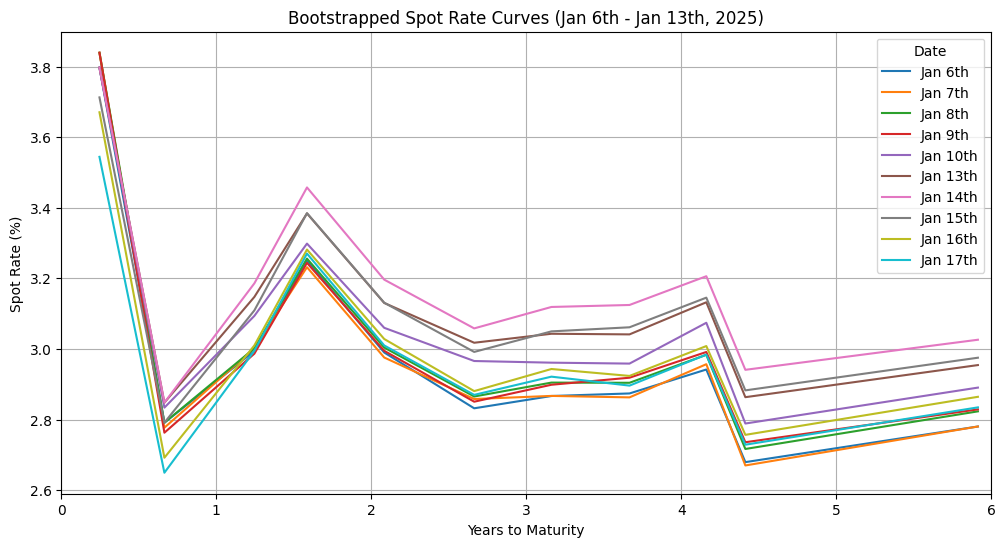

In [586]:
# --- Plotting Spot Rate Curves (Optional - similar to YTM plotting) ---
plt.figure(figsize=(12, 6))

for date_key, df in bond_data_dict_with_spot_rates.items():
    df_sorted = df.sort_values(by='TimeToMaturity')
    plt.plot(df_sorted['TimeToMaturity'], df_sorted['SpotRate'] * 100, label=date_key)

plt.xlabel('Years to Maturity')
plt.ylabel('Spot Rate (%)')
plt.title('Bootstrapped Spot Rate Curves (Jan 6th - Jan 13th, 2025)')
plt.xlim(0, 6)
plt.legend(title='Date')
plt.grid(True)
plt.savefig('spot_curves.pdf')
plt.show()

In [587]:
def calculate_forward_rate(spot_curve, start_term, forward_tenor):
    """Calculates the forward rate using discrete compounding formula (semi-annual)."""
    end_term = start_term + forward_tenor

    # Linear interpolation - No changes here (verified working from output)
    spot_rate_start = np.interp(start_term, spot_curve.index, spot_curve.values, left=np.nan, right=np.nan)
    spot_rate_end = np.interp(end_term, spot_curve.index, spot_curve.values, left=np.nan, right=np.nan)

    if np.isnan(spot_rate_start) or np.isnan(spot_rate_end):
        return np.nan  # Return NaN if spot rates are not available

    # Discrete compounding forward rate formula (semi-annual) - Assignment Hint Formula adjusted
    forward_rate = ((1 + spot_rate_end / 2)**(2 * end_term) / (1 + spot_rate_start / 2)**(2 * start_term))**(1 / (2 * forward_tenor)) - 1
    return forward_rate

In [588]:
def process_bond_data_dict_with_forward_curve(bond_data_dict_with_spot_rates):
    """Updates bond_data_dict with forward curves."""
    bond_data_dict_with_forward_rates = {}
    forward_rate_terms = [1, 2, 3, 4] # Forward tenors in years: 1yr-1yr, 1yr-2yr, 1yr-3yr, 1yr-4yr

    for date_key, df in bond_data_dict_with_spot_rates.items():
        # Ensure spot_curve index is TimeToMaturity (numerical years) - critical for interpolation
        spot_curve = pd.Series(df['SpotRate'].values, index=df['TimeToMaturity']) # Create Series with correct index

        forward_rates_for_date = {} # Store forward rates for this date

        for tenor in forward_rate_terms:
            forward_rate = calculate_forward_rate(spot_curve, start_term=1.0, forward_tenor=tenor) # Start term is fixed at 1 year
            forward_rates_for_date[f'ForwardRate_1yr{int(tenor)}yr'] = forward_rate # Store with term name

        # Direct Column Assignment - Create new columns and assign forward rates directly
        df['ForwardRate_1yr1yr'] = forward_rates_for_date.get('ForwardRate_1yr1yr')
        df['ForwardRate_1yr2yr'] = forward_rates_for_date.get('ForwardRate_1yr2yr')
        df['ForwardRate_1yr3yr'] = forward_rates_for_date.get('ForwardRate_1yr3yr')
        df['ForwardRate_1yr4yr'] = forward_rates_for_date.get('ForwardRate_1yr4yr')
        bond_data_dict_with_forward_rates[date_key] = df # Update dict

    return bond_data_dict_with_forward_rates


In [589]:
# --- Main Script ---
# (Ensure bond_data_dict_with_forward_rates is created)

# Process bond_data_dict to calculate Forward Curves
bond_data_dict_with_forward_rates = process_bond_data_dict_with_forward_curve(bond_data_dict_with_spot_rates.copy())

# --- Example: Print Bond Data with Forward Rates for Jan 6th ---
if "Jan 6th" in bond_data_dict_with_forward_rates:
    print("\nBond Data for Jan 6th with Forward Rates:")
    print(bond_data_dict_with_forward_rates["Jan 6th"][[ 'DirtyPrice','SpotRate', 'ForwardRate_1yr1yr', 'ForwardRate_1yr2yr', 'ForwardRate_1yr3yr', 'ForwardRate_1yr4yr']]) # Print only forward rate columns
else:
    print("\nNo processed data for Jan 6th.")

print("\nForward curves calculated and added to bond_data_dict.")


--- Debugging calculate_forward_rate (Formula Breakdown) ---
Start Term: 1.0, Forward Tenor: 1, End Term: 2.0
Spot Rate Start Term: 0.029082, Spot Rate End Term: 0.030335
Accumulation Factor (End Term): 1.062065
Accumulation Factor (Start Term): 1.029293
Ratio (End/Start): 1.031839
Forward Rate Factor: 1.015795
Calculated Forward Rate: 0.031590

--- Debugging calculate_forward_rate (Formula Breakdown) ---
Start Term: 1.0, Forward Tenor: 2, End Term: 3.0
Spot Rate Start Term: 0.029082, Spot Rate End Term: 0.028554
Accumulation Factor (End Term): 1.088777
Accumulation Factor (Start Term): 1.029293
Ratio (End/Start): 1.057791
Forward Rate Factor: 1.014145
Calculated Forward Rate: 0.028289

--- Debugging calculate_forward_rate (Formula Breakdown) ---
Start Term: 1.0, Forward Tenor: 3, End Term: 4.0
Spot Rate Start Term: 0.029082, Spot Rate End Term: 0.029196
Accumulation Factor (End Term): 1.122930
Accumulation Factor (Start Term): 1.029293
Ratio (End/Start): 1.090972
Forward Rate Factor:

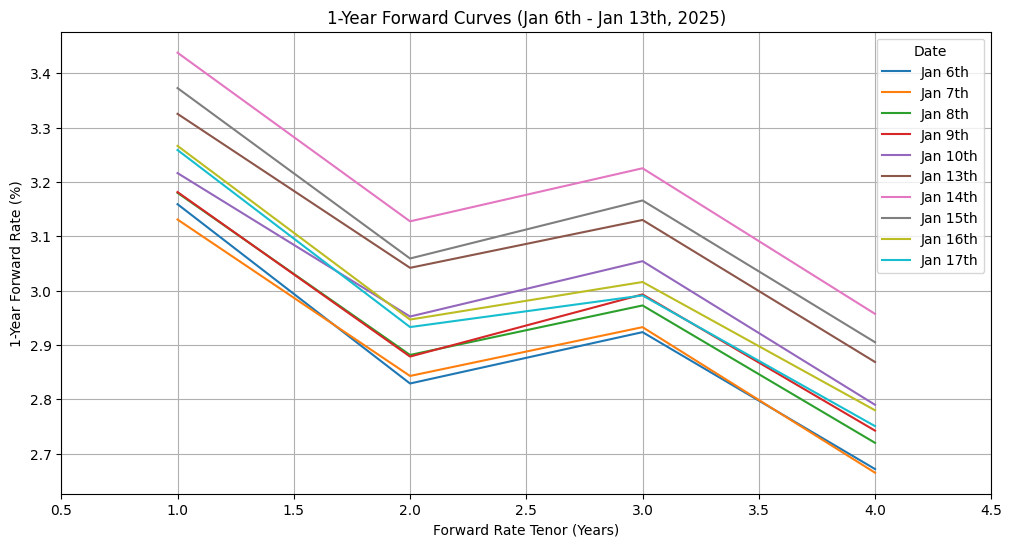

In [590]:
# --- Plotting Forward Rate Curves ---
plt.figure(figsize=(12, 6))
forward_terms_years = [1, 2, 3, 4] # X-axis labels for forward curve plot

for date_key, df in bond_data_dict_with_forward_rates.items():
    forward_rates = [df['ForwardRate_1yr1yr'].iloc[0], # Extract forward rates for plotting
                     df['ForwardRate_1yr2yr'].iloc[0],
                     df['ForwardRate_1yr3yr'].iloc[0],
                     df['ForwardRate_1yr4yr'].iloc[0]]
    plt.plot(forward_terms_years, np.array(forward_rates) * 100, label=date_key) # Plot forward rates as percentages

plt.xlabel('Years to Maturity')
plt.ylabel('1-Year Forward Rate (%)')
plt.title('1-Year Forward Curves (Jan 6th - Jan 13th, 2025)')
plt.xlim(0.5, 4.5) # X-axis range for forward tenors
plt.legend(title='Date')
plt.grid(True)
plt.savefig('forward_curves.pdf')
plt.show()

In [591]:
def calculate_covariance_pca(bond_data_dict_with_forward_rates):
    """Calculates covariance matrices for yield and forward rate log-returns and performs PCA."""
    # 1. Data Preparation for Covariance Calculation (No changes)
    dates = sorted(bond_data_dict_with_forward_rates.keys())
    ytm_rates_data = []
    forward_rates_data = []
    ytm_maturities_for_pca = [1.0, 2.0, 3.0, 4.0, 5.0] # 1yr to 5yr YTMs for PCA
    forward_rate_terms_pca = ['ForwardRate_1yr1yr', 'ForwardRate_1yr2yr', 'ForwardRate_1yr3yr', 'ForwardRate_1yr4yr'] # Forward rates for PCA
    for date_key in dates:
        df = bond_data_dict_with_forward_rates[date_key]
        ytm_values_for_date = [np.interp(maturity, df['TimeToMaturity'], df['YTM'], left=np.nan, right=np.nan) for maturity in ytm_maturities_for_pca]
        ytm_rates_data.append(ytm_values_for_date)
        forward_rate_values_for_date = [df[term].iloc[0] for term in forward_rate_terms_pca]
        forward_rates_data.append(forward_rate_values_for_date)
    ytm_rates_df = pd.DataFrame(ytm_rates_data, index=dates, columns=[f'YTM_{int(m)}yr' for m in ytm_maturities_for_pca])
    forward_rates_df = pd.DataFrame(forward_rates_data, index=dates, columns=forward_rate_terms_pca)

    # 2. Calculate Log Returns (No changes)
    ytm_log_returns = np.log(ytm_rates_df).diff().dropna() # Daily log returns of YTM
    forward_rate_log_returns = np.log(forward_rates_df).diff().dropna() # Daily log returns of Forward Rates

    # --- 2.5. STANDARDIZE LOG RETURNS BEFORE PCA ---
    ytm_log_returns_standardized = (ytm_log_returns - ytm_log_returns.mean()) / ytm_log_returns.std() # Standardization
    forward_rate_log_returns_standardized = (forward_rate_log_returns - forward_rate_log_returns.mean()) / forward_rate_log_returns.std() # Standardization


    # 3. Covariance Matrix Calculation (using STANDARDIZED log returns)
    covariance_ytm = ytm_log_returns_standardized.cov() # Use standardized log returns for covariance
    covariance_forward = forward_rate_log_returns_standardized.cov() # Use standardized log returns for covariance


    # 4. Eigenvalue and Eigenvector Decomposition (PCA) (No changes)
    eigenvalues_ytm, eigenvectors_ytm = np.linalg.eig(covariance_ytm)
    eigenvalues_forward, eigenvectors_forward = np.linalg.eig(covariance_forward)


    # 5. Output and Interpretation (Example - you need to provide more detailed interpretation in report) (No changes)
    print("\n--- Covariance Matrix of YTM Log Returns (Standardized) ---") # Updated title
    print(covariance_ytm)
    print("\nEigenvalues of YTM Covariance Matrix (Standardized):", eigenvalues_ytm) # Updated title
    print("\nEigenvectors of YTM Covariance Matrix (First Eigenvector - Standardized):\n", eigenvectors_ytm[:, 0].real) # Updated title

    print("\n--- Covariance Matrix of Forward Rate Log Returns (Standardized) ---") # Updated title
    print(covariance_forward)
    print("\nEigenvalues of Forward Rate Covariance Matrix (Standardized):", eigenvalues_forward) # Updated title
    print("\nEigenvectors of Forward Rate Covariance Matrix (First Eigenvector - Standardized):\n", eigenvectors_forward[:, 0].real) # Updated title

    print("\n--- Interpretation (Example - you need to elaborate in report) ---")
    print("\nFor YTM (Standardized):") # Updated title
    print("Largest Eigenvalue:", eigenvalues_ytm[0].real)
    print("Associated Eigenvector (First Principal Component - approx. 'level' or 'shift'):", eigenvectors_ytm[:, 0].real)

    print("\nFor Forward Rates (Standardized):") # Updated title
    print("Largest Eigenvalue:", eigenvalues_forward[0].real)
    print("Associated Eigenvector (First Principal Component):", eigenvectors_forward[:, 0].real)


    return covariance_ytm, eigenvalues_ytm, eigenvectors_ytm, covariance_forward, eigenvalues_forward, eigenvectors_forward

In [592]:
# --- Main Script ---
# (Ensure bond_data_dict_with_forward_rates is created)

# Process bond_data_dict to calculate Covariance Matrices and PCA
covariance_ytm, eigenvalues_ytm, eigenvectors_ytm, covariance_forward, eigenvalues_forward, eigenvectors_forward = calculate_covariance_pca(bond_data_dict_with_forward_rates.copy())
print("\nCovariance matrices and PCA results calculated and printed.")


--- Covariance Matrix of YTM Log Returns (Standardized) ---
          YTM_1yr   YTM_2yr   YTM_3yr   YTM_4yr   YTM_5yr
YTM_1yr  1.000000  0.775385  0.675416  0.729371  0.639893
YTM_2yr  0.775385  1.000000  0.973085  0.969491  0.961205
YTM_3yr  0.675416  0.973085  1.000000  0.979616  0.977835
YTM_4yr  0.729371  0.969491  0.979616  1.000000  0.985659
YTM_5yr  0.639893  0.961205  0.977835  0.985659  1.000000

Eigenvalues of YTM Covariance Matrix (Standardized): [4.49294263e+00 4.53794997e-01 3.41947754e-03 3.20375483e-02
 1.78053456e-02]

Eigenvectors of YTM Covariance Matrix (All Eigenvectors):
Eigenvector 1:
 [-0.37450476 -0.46747174 -0.46185343 -0.46679719 -0.45826647]
Eigenvector 2:
 [ 0.90215523 -0.0204107  -0.24761939 -0.14097864 -0.32327851]
Eigenvector 3:
 [ 0.17863072 -0.34748851  0.26941577 -0.64736835  0.59638257]
Eigenvector 4:
 [ 0.10388252 -0.63832958 -0.36736867  0.55776011  0.3683581 ]
Eigenvector 5:
 [-0.05622817  0.50283263 -0.71960507 -0.17900638  0.44059391]

--- Covar